#environment setup

## loading packages

In [1]:
import os
import numpy as np
import pandas as pd

# deep learning package
# !pip install keras
# !pip install tensorflow
import keras as ks
import tensorflow as tf

# DICOM package
# !pip install pydicom
import pydicom

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [3]:
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(gpus[1], 'GPU')

## check the version of tensorflow and keras 

In [4]:
print(f"tf version:{tf.__version__}")
print(f"ks version:{ks.__version__}")

tf version:2.7.0
ks version:2.7.0


## change workspace

In [5]:
path = '/mnt/ec/ness/ken/workspace/case2/digital-medicine-2021-case-presentation-2/'
os.chdir(path)
os.listdir()

['data_info.csv',
 '.ipynb_checkpoints',
 'image',
 'output',
 'data',
 'model_parameter.hd5',
 'sample_submission.csv']

In [6]:
batch_size = 32
img_size = (320,320)

## data preprocessing

https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165#file-dcmdataframeiterator-py-L4

In [7]:
dataspace = '.'
os.listdir(dataspace)

['data_info.csv',
 '.ipynb_checkpoints',
 'image',
 'output',
 'data',
 'model_parameter.hd5',
 'sample_submission.csv']

In [8]:
imagepath=os.path.join(dataspace,'data','data','train')
os.listdir(imagepath)[:10]

['200238f5e3a0',
 '5d28267795b8',
 'd580f1339930',
 '4c3764930e27',
 'a790956c8287',
 '1842a80d37a9',
 '099036ea23ed',
 '3dad15501561',
 '807c7e464637',
 'e1a404331897']

In [9]:
version = 'version2'
output_path=(os.path.join(dataspace, 'output',version))

if not os.path.exists(output_path):
    os.mkdir(output_path)

In [10]:
import pydicom
# !pip install opencv-python
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator

# tested on tf 2.1 

class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        # self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        # batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str
        batch_y = np.array(self.y.iloc[indices_array]) 
        
        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(256, 256), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = (image_array - np.mean(image_array)) / (np.std(image_array - np.mean(image_array))) 
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)
        return image_array

# augmentation parameters
# you can use preprocessing_function instead of rescale in all generators
# if you are using a pretrained network
train_augmentation_parameters = dict(
    rescale=1.0/255.0,
#     rotation_range=10,
#     zoom_range=0.2,
    # horizontal_flip=True,
#     fill_mode='nearest',
#     brightness_range = [0.8, 1.2],
    validation_split = 0.2
)

valid_augmentation_parameters = dict(
    rescale=1.0/255.0,
    validation_split = 0.2
)

test_augmentation_parameters = dict(
    rescale=1.0/255.0
)

# training parameters
BATCH_SIZE = 20
CLASS_MODE = 'multi_output'
COLOR_MODE = 'grayscale'
TARGET_SIZE = (128, 128)
EPOCHS = 200
SEED = 1337

train_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  
    'subset': 'training'
}

valid_consts = {
    'seed': SEED,
    'batch_size': BATCH_SIZE,
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE, 
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  # should be 1 in testing
    'class_mode': CLASS_MODE,
    'color_mode': COLOR_MODE,
    'target_size': TARGET_SIZE,  # resize input images
    'shuffle': False
}




In [11]:
# Using the training phase generators 
train_augmenter = ImageDataGenerator(**train_augmentation_parameters)
valid_augmenter = ImageDataGenerator(**valid_augmentation_parameters)
test_augmenter = ImageDataGenerator(**test_augmentation_parameters)

In [12]:
DCMFiles = [] 
file_name = []
for dirName, subdirList, fileList in os.walk(imagepath):
  for filename in fileList:
    if ".dcm" in filename.lower():
      file_name.append(filename[:-4])
      DCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles))
DCMFiles[:5]

Number of (.dcm) files = 1200


['./data/data/train/200238f5e3a0/0475b3c0444d/bd6854b1a5c2.dcm',
 './data/data/train/5d28267795b8/05d6617ead55/4f98ad71a739.dcm',
 './data/data/train/d580f1339930/3d341e533c68/3180ed684d91.dcm',
 './data/data/train/4c3764930e27/7230457f767a/309a6770492b.dcm',
 './data/data/train/a790956c8287/4b6f5164e3f2/75f2e2a4dfc4.dcm']

In [13]:
pydicom.read_file(DCMFiles[1]).pixel_array.shape

(2400, 2880)

In [14]:
df_info  = pd.read_csv(os.path.join(dataspace,'data_info.csv'),index_col='FileID')
df_info = df_info.loc[file_name]
df_info['filename'] = DCMFiles
df_info.loc[df_info['Negative']==1,'class'] = 'Negative'
df_info.loc[df_info['Typical']==1,'class'] = 'Typical'
df_info.loc[df_info['Atypical']==1,'class'] = 'Atypical'
print(df_info.shape)
df_info.head()


(1200, 5)


,Negative,Typical,Atypical,filename,class
FileID,,,,,
bd6854b1a5c2,0,1,0,./data/data/train/200238f5e3a0/0475b3c0444d/bd...,Typical
4f98ad71a739,0,0,1,./data/data/train/5d28267795b8/05d6617ead55/4f...,Atypical
3180ed684d91,1,0,0,./data/data/train/d580f1339930/3d341e533c68/31...,Negative
309a6770492b,0,1,0,./data/data/train/4c3764930e27/7230457f767a/30...,Typical
75f2e2a4dfc4,1,0,0,./data/data/train/a790956c8287/4b6f5164e3f2/75...,Negative


In [15]:
import cv2
import pydicom
import numpy as np
def normalize(image_array):
  return (image_array - np.mean(image_array)) / (np.std(image_array - np.mean(image_array))) 

def DICOM_image(data_path):
  return pydicom.dcmread(dcm_path).pixel_array

In [16]:
train_generator = DCMDataFrameIterator(
                             dataframe=df_info,
                             x_col='filename',
                             y_col=["Negative", "Typical",	"Atypical"],
                            #  y_col='class',
                             image_data_generator=train_augmenter,
                             **train_consts)

valid_generator = DCMDataFrameIterator(
                             dataframe=df_info,
                             x_col='filename',
                             y_col=["Negative", "Typical",	"Atypical"],
                            #  y_col='class',
                             image_data_generator=valid_augmenter,
                             **valid_consts)

Found 960 validated image filenames.
Found 240 validated image filenames.


In [17]:
imagepath=os.path.join(dataspace,'data','data','valid')
os.listdir(imagepath)[:10]

['9261f2b83b31',
 '320b1751917e',
 '98f92434f32c',
 'a93048663f63',
 '3984c6464e79',
 '82f7010e0302',
 '6542cfb29498',
 '9b3948685c9d',
 '432a4f610377',
 'd07f22c3e616']

In [18]:
DCMFiles = [] 
file_name = []
for dirName, subdirList, fileList in os.walk(imagepath):
  for filename in fileList:
    if ".dcm" in filename.lower():
      file_name.append(filename[:-4])
      DCMFiles.append(os.path.join(dirName,filename))
print("Number of (.dcm) files =", len(DCMFiles))
DCMFiles[:5]

Number of (.dcm) files = 150


['./data/data/valid/9261f2b83b31/0155b26237ce/0f30ecaf1e42.dcm',
 './data/data/valid/320b1751917e/85bd059a7b8c/383c177fdfa3.dcm',
 './data/data/valid/98f92434f32c/82201da05577/883d3e798939.dcm',
 './data/data/valid/a93048663f63/713a9950ca3a/b4cab73348f4.dcm',
 './data/data/valid/3984c6464e79/0c9031a0f654/6fe28c9fd729.dcm']

In [19]:
df_test = pd.DataFrame()
df_test['FileID'] = file_name
df_test = df_test.set_index('FileID')
df_test['filename'] = DCMFiles
df_test['Negative'] = 0
df_test['Typical'] = 0
df_test['Atypical'] = 0

print(df_test.shape)
df_test.head()

(150, 4)


,filename,Negative,Typical,Atypical
FileID,,,,
0f30ecaf1e42,./data/data/valid/9261f2b83b31/0155b26237ce/0f...,0,0,0
383c177fdfa3,./data/data/valid/320b1751917e/85bd059a7b8c/38...,0,0,0
883d3e798939,./data/data/valid/98f92434f32c/82201da05577/88...,0,0,0
b4cab73348f4,./data/data/valid/a93048663f63/713a9950ca3a/b4...,0,0,0
6fe28c9fd729,./data/data/valid/3984c6464e79/0c9031a0f654/6f...,0,0,0


In [20]:
test_generator = DCMDataFrameIterator(
                             dataframe=df_test,
                             x_col='filename',
                             y_col=["Negative", "Typical",	"Atypical"],
                            #  y_col='class',
                             image_data_generator=test_augmenter,
                             **test_consts)

Found 150 validated image filenames.


In [21]:
# df_info  = pd.read_csv(os.path.join(dataspace,'data_info.csv'),index_col='FileID')
# df_info = df_info.loc[file_name]
# df_info['filename'] = DCMFiles
# df_info.loc[df_info['Negative']==1,'class'] = 'Negative'
# df_info.loc[df_info['Typical']==1,'class'] = 'Typical'
# df_info.loc[df_info['Atypical']==1,'class'] = 'Atypical'
# print(df_info.shape)
# df_info.head()


In [22]:
temp_image, temp_class = train_generator.next()
# train_generator
train_generator.reset()

In [23]:
# np.squeeze(temp_image[i], axis=(2,)).shape
temp_image.shape

(20, 128, 128, 1)

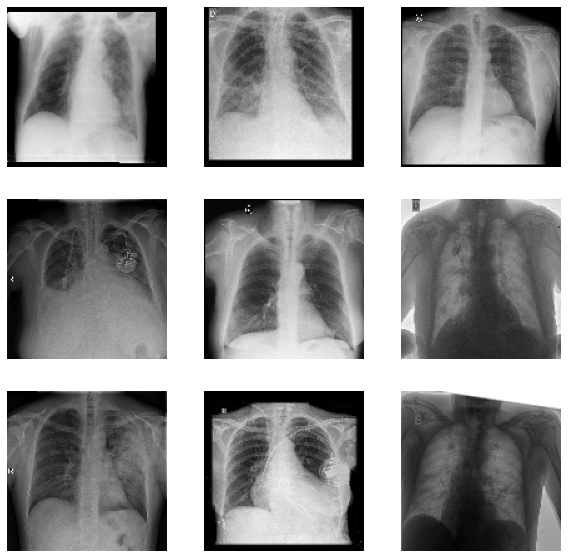

In [24]:
# class_names = train_generator.classes

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.squeeze(temp_image[i], axis=(2,)), cmap='gray')
  # plt.title(temp_class[i])
  plt.axis("off")

## model

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten, MaxPool2D, BatchNormalization

In [26]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],1), padding='same',activation='relu'),
    Conv2D(32,(3,3),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64,(3,3),activation='relu', padding='same'),
    Conv2D(64,(3,3),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(64,(3,3),activation='relu', padding='same'),
    Conv2D(64,(3,3),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Conv2D(32,(3,3),activation='relu', padding='same'),
    Conv2D(32,(3,3),activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(),
    Flatten(),
    
    Dense(1024, activation='relu'),
    Dense(1024, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax'),
                    
])


In [27]:
# input_shape = (imageSize, imageSize, 1)
# model = Sequential([
#     Conv2D(32, (3, 3), input_shape=input_shape, padding='same',activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(96, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(96, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#      Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
#     Dropout(0.2),
    
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(len(classes), activation='softmax')
# ])

In [28]:
# model = tf.keras.applications.vgg16.VGG16(
#     include_top=True, weights=None, input_tensor=None,
#     input_shape=TARGET_SIZE + (1,), pooling=None, classes=3,
#     classifier_activation='relu'
# )


In [29]:
from tensorflow.keras.optimizers import Adam, SGD
adam = Adam(lr=0.0001)
sgd = SGD(lr=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

/home/ken/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/ken/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        3

In [ ]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-3),
    tf.keras.callbacks.ModelCheckpoint(filepath='./model.h5', monitor='val_loss', 
                                       save_best_only=False, verbose=1)
]
# training
# train_history = model.fit_generator(
# 	generator=train_generator,
# 	steps_per_epoch=len(train_generator),
# 	epochs=EPOCHS,
#     callbacks=callbacks,
# 	validation_data=valid_generator,
# 	validation_steps=len(valid_generator),
#     verbose=1
# )

<ipython-input-28-e57ee1b9393e>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  train_history = model.fit_generator(


Epoch 1/200
48/48 [==============================] - ETA: 0s - loss: 1.1410 - accuracy: 0.4667
Epoch 00001: saving model to ./model.h5
48/48 [==============================] - 239s 5s/step - loss: 1.1410 - accuracy: 0.4667 - val_loss: 1.1327 - val_accuracy: 0.3375
Epoch 2/200
48/48 [==============================] - ETA: 0s - loss: 1.1211 - accuracy: 0.4958
Epoch 00002: saving model to ./model.h5
48/48 [==============================] - 232s 5s/step - loss: 1.1211 - accuracy: 0.4958 - val_loss: 1.1340 - val_accuracy: 0.3792
Epoch 3/200
48/48 [==============================] - ETA: 0s - loss: 1.0172 - accuracy: 0.5104
Epoch 00003: saving model to ./model.h5
48/48 [==============================] - 229s 5s/step - loss: 1.0172 - accuracy: 0.5104 - val_loss: 1.1275 - val_accuracy: 0.4042
Epoch 4/200
48/48 [==============================] - ETA: 0s - loss: 0.9775 - accuracy: 0.5521
Epoch 00004: saving model to ./model.h5
48/48 [==============================] - 228s 5s/step - loss: 0.9775 -

In [31]:
model.load_weights(os.path.join(output_path,'model.h5'))

## learning curve

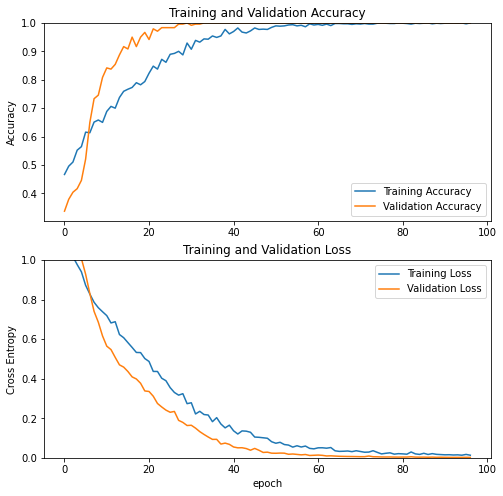

In [34]:
acc = train_history.history['accuracy']
val_acc = train_history.history['val_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('learning curve.png')
plt.show()


In [38]:
df_tmp = pd.DataFrame(train_history.history)
df_tmp.to_csv('log_model_training.csv')

In [61]:
temp = model.predict_generator(test_generator)

<ipython-input-61-eada5191d386>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  temp = model.predict_generator(test_generator)


In [66]:
list_type = ["Negative", "Typical",	"Atypical"]
index_predict = np.argmax(temp, axis=1) 
predict_class = [list_type[i] for i in index_predict]
print(index_predict[:5])
print(predict_class[:5])
temp[:5]

[2 0 0 1 0]
['Atypical', 'Negative', 'Negative', 'Typical', 'Negative']


array([[7.7923656e-02, 1.9258735e-01, 7.2948903e-01],
       [8.3075958e-01, 1.9619716e-02, 1.4962077e-01],
       [6.9474065e-01, 2.6766369e-01, 3.7595697e-02],
       [7.7205256e-04, 9.9514633e-01, 4.0816544e-03],
       [9.2905599e-01, 5.4137962e-04, 7.0402645e-02]], dtype=float32)

In [80]:
df_temp = pd.read_csv('sample_submission.csv')
df_temp['FileID']

0      014cc6362544
1      014f6b975233
2      04d7e099eafa
3      05a7f46635c7
4      05e002867b16
           ...     
145    f6a9cee1149d
146    f75463651b85
147    f7f391fe9a3c
148    fb31eeb4f056
149    fd0516801814
Name: FileID, Length: 150, dtype: object

In [81]:
df_test["Type"] = predict_class 

In [82]:
df_test = df_test.loc[df_temp['FileID'],:]
del df_temp

df_test['Type'].to_csv('output.csv', index_label='FileID')

## confusion

In [32]:
import math
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [33]:
model.evaluate_generator(train_generator)

<ipython-input-33-e4ade065aa26>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_generator)


[0.0019620696548372507, 1.0]

In [34]:
model.evaluate_generator(valid_generator)

<ipython-input-34-96c8e4e60112>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_generator)


[0.0020561236888170242, 1.0]

In [36]:
list_class = ["Negative", "Typical", "Atypical"]

<Figure size 432x288 with 0 Axes>

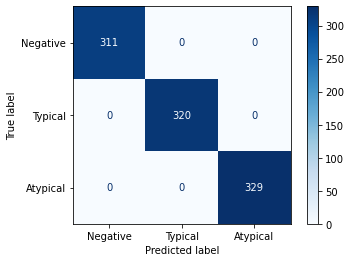

In [38]:
temp_y = [list_class[i] for i in np.argmax(np.transpose(np.array(train_generator.labels)),axis=1)]
y_true = []
y_pred = []
for i in range(math.ceil(len(temp_y)/BATCH_SIZE)):
    temp_image, temp_class = train_generator.next()
    y_pred = y_pred + list(np.argmax(model.predict(temp_image),axis=1))
    y_true = y_true + list(np.argmax(temp_class,axis=1))


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true,y_pred), display_labels=list_class)
plt.savefig(os.path.join(output_path,'train_CM.png'))
disp.plot(cmap=plt.cm.Blues)
plt.show()

<Figure size 432x288 with 0 Axes>

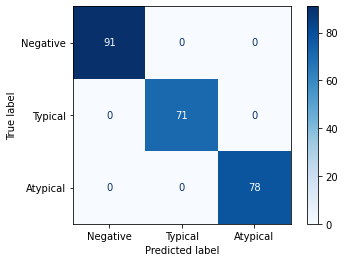

In [39]:
temp_y = [list_class[i] for i in np.argmax(np.transpose(np.array(valid_generator.labels)),axis=1)]
y_true = []
y_pred = []
for i in range(math.ceil(len(temp_y)/BATCH_SIZE)):
    temp_image, temp_class = valid_generator.next()
    y_pred = y_pred + list(np.argmax(model.predict(temp_image),axis=1))
    y_true = y_true + list(np.argmax(temp_class,axis=1))


disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true,y_pred), display_labels=list_class)
plt.savefig(os.path.join(output_path,'valid_CM.png'))
disp.plot(cmap=plt.cm.Blues)
plt.show()